#A Second Look at the Statistics of Mass Shootings

This is a follow-up to an incredibly insightful [post](http://www.charlespetzold.com/blog/2015/07/De-Obfuscating-the-Statistics-of-Mass-Shootings.html) by Charles Petzold.
You really should read it first, it's quite excellent.

He examines statistical noise and shows that the _per capita_ rate of mass shootings is a stupid measure because there simply isn't enough data.
He also demonstrates that the US would need to have roughly twice the population it does for it to have a representative portion of the mass shootings in the dataset.

This is a different look at the same dataset (obtained [here](http://archive.is/f4gbv), but trimmed down a bit).
We're going to look at how Bayesian statistics can answer the following questions for us:

> Does the US have an unnaturally high number of mass shootings relative to the other countries in the dataset?
>
> If so (it is), how bad is it?

## First Blush

So the assumption we want to verify is that the US has an expected number of mass shootings given it's population for the rest of the dataset.
We can load the data and take a look at these numbers pretty easily.

**Warning**: what follows will probably make you sad.

In [1]:
import pandas as pd
import numpy as np
from __future__ import division
%matplotlib inline

# Data is assumed to be in the same directory.
mass_shootings = pd.read_csv("mass_shootings.csv", index_col="country")

total_population = sum(mass_shootings.population)

us_population_fraction = mass_shootings.loc['United States'].population / total_population
rest_of_population_fraction = 1 - us_population_fraction

us_mass_shootings = mass_shootings.loc["United States"].rampage_shootings
total_mass_shootings = mass_shootings.rampage_shootings.sum()

print("US fraction of total population: %-6.2f" % us_population_fraction)
print("Non-US fraction of total population: %-6.2f" % rest_of_population_fraction)
print
print("US total mass shootings: %d (%.2f)" %
      (us_mass_shootings,(us_mass_shootings / total_mass_shootings)))
print("Non-US total mass shootings: %d (%.2f)" % 
      ((total_mass_shootings - us_mass_shootings), (1 - (us_mass_shootings / total_mass_shootings))))

US fraction of total population: 0.25  
Non-US fraction of total population: 0.75  

US total mass shootings: 38 (0.62)
Non-US total mass shootings: 23 (0.38)


So, a country with a quarter of the population is responsible for well over half of the total number of rampage shootings from the countries measured.
Seems suspicious.
What is the probability that we're looking at noise?
Well, that question is answered with the [_binomial test_](https://en.wikipedia.org/wiki/Binomial_test).

If we make the assumption that the rampage shootings are evenly distributed across the _total population_, then the US's share should be centered around 0.25. 
If we write this as a Binomial distribution with 61 trials (38 + 23) and 38 "successes" with a probability of 0.25, not only do we get a morbidly disturbing statistical experiment, but a nice number that tells us just how likely it is that we _don't_ have a mass shooting problem.

In [2]:
import scipy.stats as sts

sts.binom.sf(38, n=61, p=0.25) # This is the one tailed test (1-cdf).

1.5947056420909307e-10

That is a laughably small number.
Or it would be if it wasn't so sad.

What this doesn't tell us is what the probability _should_ be, or how certain we are of it.
For that, we're going to bring in the 800 pound gorilla of Bayesian inference: Markov Chain Monte Carlo.

## Bayesian Statistics

Before we get into MCMC, let's talk just a little bit about Bayesian inference without complicated equations and other BS.
First we need to frame what we're specifically looking for, so I'm going to do that right now.
It starts with the data: we've basically reduced our dataset into two points: number of mass shootings in the US, and number of shootings not in the US.

What we're attempting to infer is, _given a mass shooting incident, what is the probability that it occurs in the United States_?
If that probability is significantly different from the proportion of the population the US represents, we have an "above average" problem here (hint: we've already answered this, and it is yes).
What Bayesian inference allows us to do is specify what we _think_ the probability of a mass shooting being in the US is, and modify that based on the data presented.

So, as a random (not really random) example, we can specify that we think the probability of a mass shooting being in the US is a flat line between zero and one.
This represents the minimal assumption about the value.
Or we could encode our population information about it, and state that it is our _opinion_ it should be about 0.25, with some uncertainty.
The assumption about the probability we're trying to determine is called a _prior_ because it represents our knowledge of the system before any evidence (data) is observed.
When we incorporate that evidence, we get a _posterior_ on the quantity.

**ASIDE**: Note that we're talking about probability distributions of a _probability itself_.
It's a little Inceptiony, but what this basically boils down to is that we're uncertain about what that probability should be.
The 0.61 number we expect to see from the data comes from data, which itself is noisy.
The uncertainty is expressed by returning a distribution.

So the answer we get is not a single value like the binomial test.
We can always roll up the distribution with some measure of central tendency like mean or median when we need it though.

## Markov Chain Monte Carlo

Markov Chain Monte Carlo (MCMC - we won't discuss what's Markov-chainy here, it's kind of complicated) is a sampling technique that can be used to perform inference of really complicated distributions, even distributions that are made up of other distributions like what we have.
It does this by simulating the values from the individual distributions and converging on a solution through what is basically an optimization scheme.
Instead of finessing though some complicated closed-form calculation which is probably not possible in the first place, it uses brute computational power.

Luckily our distribution is pretty simple.
So simple, in fact, it can be [analytically solved](https://en.wikipedia.org/wiki/Beta-binomial_distribution). 
But, then you'd be looking at a bunch of equations and not-as-pretty pictures.

### The Model

So our model is this: we choose a uniform prior between zero and one.
There are a few ways to write this, and for reasons that will become clear later, we'll write this with a [beta](https://en.wikipedia.org/wiki/Beta_distribution) distribution, $p \sim Beta(1,1)$.
Betas sit between zero and one, and can take a huge variety of shapes, including the flat uniform.
They're handy.

The actual shooting count will be a [binomial](https://en.wikipedia.org/wiki/Binomial_distribution) whose probability is set to the distribution of the prior, with number of trials equal to the total number of incidents and number of "successes" being the number of shootings in the US, $n_s \sim Binom(n_{us}~|~ p, n_{total}) = Binom(38 ~|~ p, 61)$.
This function $Binom(38 ~|~ p, 61) \sim f(p)$ is called the _likelihood_, in case you're wondering.
It's basically a pdf that's a function of the parameter instead of the observations.

In [3]:
import pymc 

# This is model setup. First we define our random variables.
shooting_prob_unif = pymc.Beta('shooting_prob', 1,1)
# Note that we're using a variable itself for the p parameter.
# This is how hierarchical models work.
shooting_count_unif = pymc.Binomial('shooting_count', n=61, p=shooting_prob_unif, value=[38], observed=True)
shooting_model_unif = pymc.MCMC([shooting_prob_unif, shooting_count_unif])

# Now perform the sampling. This takes a few seconds.
shooting_model_unif.sample(iter=100000, burn=1000, thin=10)

 [-----------------100%-----------------] 100000 of 100000 complete in 5.5 sec

So we've drawn the samples - now we can take a look at what the distribution of $p$ looks like.

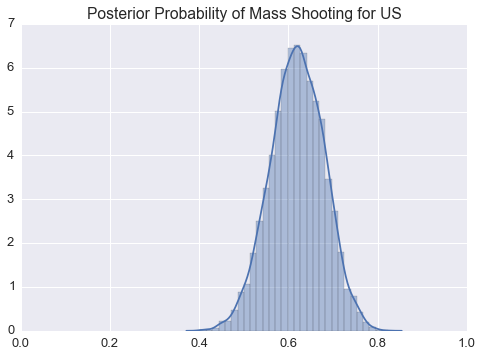

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("notebook", font_scale=1.3)

ax = sns.distplot(shooting_model_unif.trace('shooting_prob')[:], bins=30)
ax.set_xlim([0.0,1.0])
ax.set_title("Posterior Probability of Mass Shooting for US")
plt.show()

So the p distribution is centered around about 0.6, which is the fraction of mass shooting incidents indicated by the data.
The distribution tells us more than that though (otherwise what's the point?).
It tells us the uncertainty of the probability value.
In this case it's pretty wide.
I would reasonably believe the "true" value could be anwhere from 0.45 to 0.75, which is like 25% on either side of 0.6.
The reason for this spread is the amount of data.
38/61 isn't a huge number of points, not nearly as much as, say, 100/200 or 1000/2000.
That said, I want to be clear this is one case where I'm kind-of glad I don't have more data.

Let's look at a couple of summary statistics: mean, standard deviation, and inter-quartile range.

In [5]:
def summary_stats(trace):
    q75,q25 = np.percentile(trace, [75,25])
    print("%-10s: %f" % ("mean", np.mean(trace)))
    print("%-10s: %f" % ("sd", np.std(trace)))
    print("%-10s: %f" % ("iq range", (q75 - q25)))
    
summary_stats(shooting_model_unif.trace('shooting_prob')[:])

mean      : 0.619658
sd        : 0.060084
iq range  : 0.082075


One more question before moving on.
What's the probability under this posterior of the assumption that the US has a probability of mass shooting of 0.25?

Remember, 0.25 is the number that says, _"We're not any worse off than other countries"_.

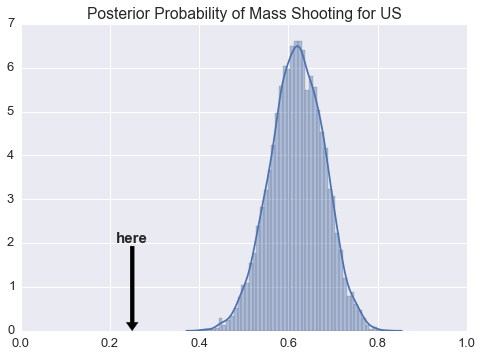

In [6]:
# We'll bundle this into a function because we'll be using it a couple of times.
def add_arrow(axis):
    axis.annotate("here", xy=(0.25,0), xycoords='data',
                   xytext=(0.25,2), textcoords='data',
                   arrowprops=dict(facecolor="black"),
                   horizontalalignment="center",
                   fontsize=15,
                   fontweight="bold")
    
ax = sns.distplot(shooting_model_unif.trace('shooting_prob')[:], bins=50)
ax.set_xlim([0.0,1.0])
ax.set_title("Posterior Probability of Mass Shooting for US")
add_arrow(ax)
plt.show()

Well that's shocking.




It's not though.

So what if we _did_ want to bias the initial values for p?
What if we were really convinced that the US was just as bad off as everyone else?
We could encode that position in the prior, and re-run the simulation.
How do we choose the ideal parameters?
We could pick a mean and standard deviation and solve for them like a real math person, or we could just plot it and pick something that looks decent.

The mean of a $Beta(\alpha,\beta)$ is $\frac{\alpha}{\alpha + \beta}$.
If we want that mean to be 0.25, we have several options:

* $\alpha = 0.25, \beta = 0.75$
* $\alpha = 1, \beta = 3$
* $\alpha = 2, \beta = 6$

... and so forth.

Our other requirement is that the prior drop _off_ away from the mean.
As you'll see in a minute, that's not necessarily true for all of these priors.

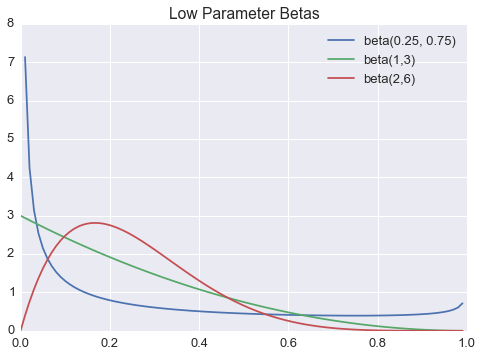

In [7]:
# x-value range to apply the function.
beta_x_values = np.arange(0.0,1.0,0.01)

# This will come in handy too.
def beta_pdf(values, alpha, beta):
    return map(lambda x: sts.distributions.beta(alpha, beta).pdf(x), values)
    
beta_25_75 = beta_pdf(beta_x_values, 0.25, 0.75)
beta_1_3 = beta_pdf(beta_x_values, 1, 3)
beta_2_6 = beta_pdf(beta_x_values, 2, 6)

_, ax = plt.subplots()
ax.plot(beta_x_values, beta_25_75, label="beta(0.25, 0.75)")
ax.plot(beta_x_values, beta_1_3, label="beta(1,3)")
ax.plot(beta_x_values, beta_2_6, label="beta(2,6)")
ax.legend(loc="upper right")
ax.set_title("Low Parameter Betas")
plt.show()

None of these are great, but $Beta(2,6)$ looks like it's headed the right direction.
Let's look at one more: $Beta(4,12)$.
I'll put $Beta(2,6)$ up there too to show the difference.

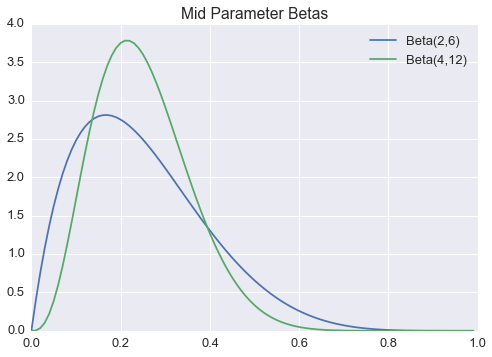

In [8]:
beta_4_12 = beta_pdf(beta_x_values, 4, 12)

_,ax = plt.subplots()
ax.plot(beta_x_values, beta_2_6, label="Beta(2,6)")
ax.plot(beta_x_values, beta_4_12, label="Beta(4,12)")
ax.legend(loc="upper right")
ax.set_title("Mid Parameter Betas")
plt.show()

Now we're getting somewhere.
We can use $Beta(4,12)$ as a prior and see how much it gets moved by the data.

Keep in mind that what this means is that we are actually biased towards a p = 0.25 value, meaning we're biased toward the fact that the US _isn't_ worse off than the other nations in the dataset when it comes to the number of mass shootings.

In [9]:
shooting_prob_weak = pymc.Beta('shooting_prob', 4, 12)
shooting_count_weak = pymc.Binomial('shooting_count', p=shooting_prob_weak, n=61, value=[38], observed=True)
shooting_model_weak = pymc.MCMC([shooting_prob_weak, shooting_count_weak])
shooting_model_weak.sample(iter=100000, burn=1000, thin=10)

 [-----------------100%-----------------] 100000 of 100000 complete in 5.6 sec

Okay, let's look at the posterior.
I'll annotate the 0.25 point again as well.

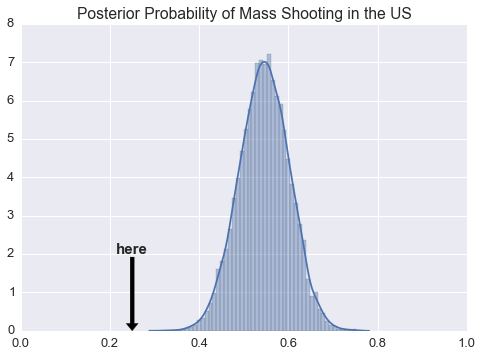

In [10]:
ax = sns.distplot(shooting_model_weak.trace('shooting_prob')[:], bins=50)
add_arrow(ax)
ax.set_xlim([0.0,1.0])
ax.set_title("Posterior Probability of Mass Shooting in the US")
plt.show()

So while the posterior as a whole is definitely pulled to the left by the prior, 0.25 is a bit of a stretch.
And by a bit, I mean pretty much not possible.

In [11]:
summary_stats(shooting_model_weak.trace('shooting_prob')[:])

mean      : 0.545900
sd        : 0.056300
iq range  : 0.076283


So let's really rachet up the prior.
Lets go to $Beta(8,24)$ and see what the probability of a 0.25 mass shooting probability is.
I'll plot it with $Beta(4,12)$ to show their relative strengths.

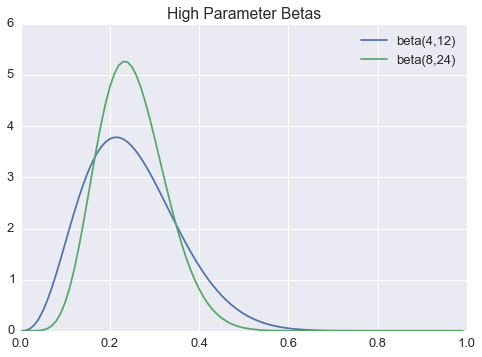

In [12]:
beta_8_24 = beta_pdf(beta_x_values, 8, 24)

_,ax = plt.subplots()
ax.plot(beta_x_values, beta_4_12, label="beta(4,12)")
ax.plot(beta_x_values, beta_8_24, label="beta(8,24)")
ax.legend(loc="upper right")
ax.set_title("High Parameter Betas")
plt.show()

That's pretty substantial bias.
Let's run the simulation one more time and see what we get.
The results should not surprise you.

In [14]:
shooting_prob_strong = pymc.Beta('shooting_prob', 8,24)
shooting_count_strong = pymc.Binomial('shooting_count', p=shooting_prob_strong, n=61, value=[38], observed=True)

shooting_model_strong = pymc.MCMC([shooting_prob_strong, shooting_count_strong])
shooting_model_strong.sample(iter=100000, burn=1000, thin=10)

 [-----------------100%-----------------] 100000 of 100000 complete in 6.7 sec

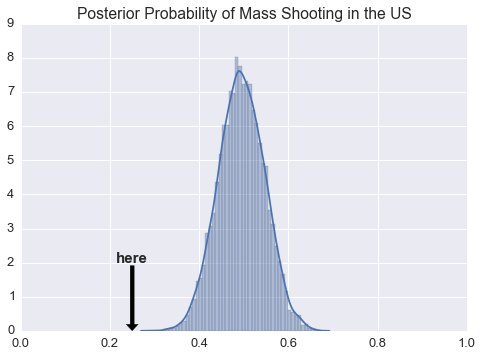

In [15]:
ax = sns.distplot(shooting_model_strong.trace('shooting_prob')[:], bins=50)
add_arrow(ax)
ax.set_xlim([0.0,1.0])
ax.set_title("Posterior Probability of Mass Shooting in the US")
plt.show()

Oh look, we're almost touching the line.

In [16]:
summary_stats(shooting_model_strong.trace('shooting_prob')[:])

mean      : 0.494853
sd        : 0.051616
iq range  : 0.070672


Are there even any samples equal to or less than 0.25?

In [17]:
print("Number of samples supporting \"not a problem\": %d" % 
      len(filter(lambda x: x <= 0.25, shooting_model_strong.trace('shooting_prob')[:])))

Number of samples supporting "not a problem": 0


Even if we very strongly bias our initial estimate of a mass shooting's chances of coming from the US towards "it's not worse than anywhere else" we still get a really small chance of that actually being the case.
The evidence against it is staggering.
Out of ten thousand samples, not even one is less than or equal to 0.25.

So the next time someone says the US doesn't have a mass shooting problem, this dataset says there's a more than 99.99% chance they're full of shit.